# XenonPy-iQSPR tutorial

This tutorial provides step by step guidance to all the essential components for running iQSPR, an inverse molecular design algorithm based on machine learning. We provide a set of in-house data and pre-trained models for demonstration purpose. We reserve all rights for using these resources outside of this tutorial. We recommend readers to have prior knowledge about python programming, use of numpy and pandas packages, building models with scikit-learn, and understanding on the fundamental functions of XenonPy (refer to the tutorial on the descriptor calculation and modeling building with XenonPy). For any question, please contact the developer of XenonPy.

Overview - iQSPR is based on Bayesian inference with sequential Monte Carlo sampling, which requires a likelihood model and a prior model to begin with. This tutorial will proceed as follow: (1) initial setup and data preparation, (2) descriptor preparation for forward model (likelihood), (3) forward model (likelihood) preparation, (4) N-gram (prior) preparation, (5) a complete iQSPR run.

### Useful functions

First, we import some basic libraries and functions that are not directly related to the use of iQSPR. You may look into the "tools.ipynb" for the content. We also pre-set a numpy random seed for reproducibility. The same seed number is used throughout this tutorial.

In [52]:
%run tools.ipynb

np.random.seed(201903)


### Data preparation (in-house data)

Here is a data set that contains 16674 SMILES randomly selected from pubchem with 2 material properties, the internal energy E (kJ/mol) and the HOMO-LUMO gap (eV). The property values are obtained from single-point calculations in DFT (density functional theory) simulations, with compounds geometry optimized at the B3LYP/6-31G(d) level of theory using GAMESS. This data set is prepared by our previous developers of iQSPR. XenonPy supports pandas dataframe as the main input source. When there are miss match in the number of data points available in each material property, i.e., there exists missing values, please simply fill in the missing values with NaN, and XenonPy will automatically handle them during model training.

In [26]:
# load in-house data from csv file
data = pd.read_csv("./iQSPR_sample_data.csv")

# take a look at the data
print(data.columns)
data.head()


Index(['Unnamed: 0', 'SMILES', 'E', 'HOMO-LUMO gap'], dtype='object')


,Unnamed: 0,SMILES,E,HOMO-LUMO gap
0,1,CC(=O)OC(CC(=O)[O-])C[N+](C)(C)C,177.577,4.352512
1,2,CC(=O)OC(CC(=O)O)C[N+](C)(C)C,185.735,7.513497
2,3,C1=CC(C(C(=C1)C(=O)O)O)O,98.605,4.581348
3,4,CC(CN)O,83.445,8.034841
4,5,C(C(=O)COP(=O)(O)O)N,90.877,5.741310


Let us visualize some statistics of the data set. We can see that the mean character length of the SMILES is around 30. This roughly corresponds to around 20 tokens in iQSPR due to the way we combine some characters into a single token to be handled during the molecule modification step. Furthermore, the data shows a clear Pareto front at the high HOMO-LUMO gap region and the lack of molecules for HOMO-LUMO gap below 2. In this tutorial, we will try to populate the region of HOMO-LUMO gap less than 2 and internal energy less than 200.

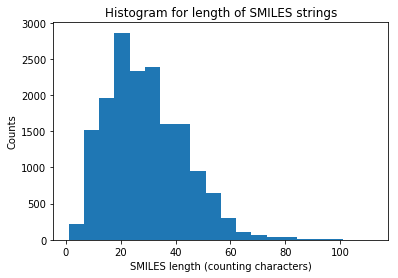

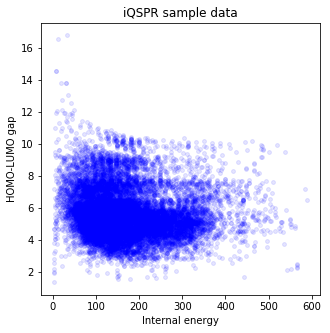

In [27]:
# check the SMILES length
count = [len(x) for x in data['SMILES']]
plt.hist(count, bins=20)  # arguments are passed to np.histogram
plt.title('Histogram for length of SMILES strings')
plt.xlabel('SMILES length (counting characters)')
plt.ylabel('Counts')
plt.show()


In [ ]:
# check target properties: E & HOMO-LUMO gap
plt.figure(figsize=(5,5))
plt.scatter(data['E'],data['HOMO-LUMO gap'],s=15,c='b',alpha = 0.1)
plt.title('iQSPR sample data')
plt.xlabel('Internal energy')
plt.ylabel('HOMO-LUMO gap')
plt.show()


A complete iQSPR run may take a very long time. For practical purposes, the full design process can be separately done in multiple steps, and we recommend taking advantage of parallel computing if possible. To save time in this tutorial, we will extract only a subset of the full in-house data set for demonstration. You will see that the subset represents the full data set in our target property space well. Readers can try to repeat this tutorial with the full data set if sufficient computing resource is available.

   index  Unnamed: 0                               SMILES        E  \
0  16101       23630            CC(C)CN1CC(C1)C2=CC=CC=C2  193.542   
1  13275       19222               C1=CC(=CN=C1)C(=O)OCCO  110.998   
2  13879       20189  C1=CC(=CC=C1CC(C(=O)O)N)N(CCCl)CCCl  202.960   
3   5313        7775                    CCCCCC(=O)OCC(C)C  191.230   
4   8254       11881         C1=CC(=C(C=C1O)C(=O)O)C(=O)O   91.482   

   HOMO-LUMO gap  
0       5.914093  
1       5.186226  
2       5.400097  
3       7.727368  
4       4.856441  


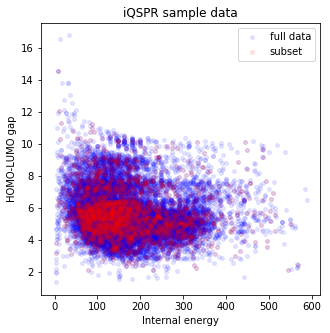

In [53]:
np.random.seed(201903) # fix the random seed

# extract a subset from the full data set
data_ss = data.sample(3000).reset_index()
print(data_ss.head())

# check target properties: E & HOMO-LUMO gap
plt.figure(figsize=(5,5))
plt.scatter(data['E'],data['HOMO-LUMO gap'],s=15,c='b',alpha = 0.1,label="full data")
plt.scatter(data_ss['E'],data_ss['HOMO-LUMO gap'],s=15,c='r',alpha = 0.1,label="subset")
plt.legend(loc='upper right')
plt.title('iQSPR sample data')
plt.xlabel('Internal energy')
plt.ylabel('HOMO-LUMO gap')
plt.show()

### Descriptor and forward model preparation

XenonPy provides flexible descriptor organizing function to the users. The first step is to import BaseDescriptor and all necessary descriptors (fingerprints) supported by XenonPy, which will be used to construct a customized set of descriptors for forward prediction. We currently support all fingerprints and descriptors in the RDKit (Mordred will be added soon). For other descriptors, users can use the BaseFeaturizer class to construct for their own needs. If so, we would appreciate very much if you could share the code as a contribution to this project.

In [ ]:
# XenonPy descriptor calculation library
from xenonpy.descriptor.base import BaseDescriptor
from xenonpy.descriptor import ECFP # chosen for this example

In this tutorial, we only use the ECFP in RDKit. You may combine multiple descriptors by adding more "self.XXX" in the BaseDescriptor. All descriptors with the same name "XXX" will be concatenated as one long descriptor. We currently support input_type to be 'smiles' or 'mols' (the RDKit internal mol format) and other basic options for each available RDKit fingerprints. The output will be a pandas dataframe that is supported scikit-learn when building forward model with various machine learning methods.

In [5]:
# prepare descriptor function from XenonPy (possible to combine multiple descriptors)
class RDKitDesc(BaseDescriptor):
    def __init__(self, n_jobs=-1):
        super().__init__()
        self.n_jobs = n_jobs

        self.rdkit_fp = ECFP(n_jobs, on_errors='nan', input_type='smiles')
        #self.rdkit_fp = MACCS(n_jobs)

RDKit_FPs = RDKitDesc()


##### train forward models inside XenonPy

***Warning: the next module may take 2-3min to complete!

The prepared descriptor class will be added to the forward model class used in iQSPR. To prepare the forward model, XenonPy provides two options: (1) use a template from XenonPy and train the model internally, and (2) prepare your own pre-trained model and feed it into the forward model class in iQSPR. 

Here, we start with the first option. Note that when fitting the model, you have to use "pd.Series" with "name" set to be the name "XXX" used in your descriptor class so that iQSPR can recognize which descriptor set to use.

In [31]:
%%time

# Forward model template in XenonPy-iQSPR 
from xenonpy.inverse.iqspr import BayesianRidgeEstimator

# write down list of property name(s) for forward models
# (they will be used as a key in whole iQSPR run)
prop = ['E','HOMO-LUMO gap']

# import descriptor class to iQSPR
prd_mdls = BayesianRidgeEstimator(descriptor=RDKit_FPs)

# train forward models inside iQSPR
ss = pd.Series(data_ss['SMILES'], name='rdkit_fp')
prd_mdls.fit(ss, data[prop])


CPU times: user 3min 59s, sys: 7.25 s, total: 4min 6s
Wall time: 2min 31s


Let us take a look at the distribution of the likelihood values for all the molecules in our data as a validation. You will see that all molecules have a small likelihood because they are far from our target region. Note that when setting the target region for the likelihood calculation, "np.inf" is supported. Also, we use only log_likelihood in iQSPR to avoid numerial issue.

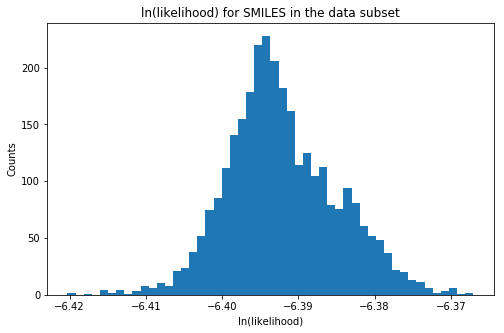

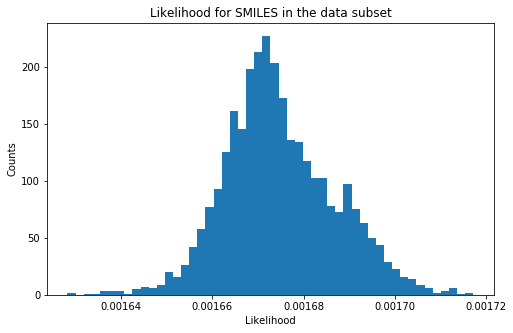

In [32]:
%%time

# calculate log-likelihood for a given target property region
ss = pd.Series(data_ss['SMILES'], name='rdkit_fp')
tmp_ll = prd_mdls.log_likelihood(ss, **{'E': (0,200), 'HOMO-LUMO gap': (-np.inf, 2)})


In [ ]:
# plot histogram of log-likelihood values
plt.figure(figsize=(8,5))
plt.hist(tmp_ll, bins=50)
plt.title('ln(likelihood) for SMILES in the data subset')
plt.xlabel('ln(likelihood)')
plt.ylabel('Counts')
plt.show()

# plot histogram of likelihood values
plt.figure(figsize=(8,5))
plt.hist(np.exp(tmp_ll), bins=50)
plt.title('Likelihood for SMILES in the data subset')
plt.xlabel('Likelihood')
plt.ylabel('Counts')
plt.show()


***Warning: the next module may take 3-5min to complete!

The second option is to prepare your own forward model. In fact, this may often be the case because you may want to first validate your model before using it. When the training takes a long time, you want to avoid repeating the calculation that is simply wasting computing resources. In this tutorial, we will use Bayesian linear model. Let us first verify the performance of the model on our data set using a 5-fold cross-validation.

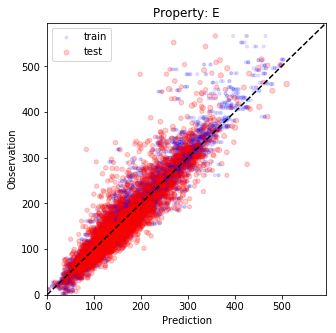

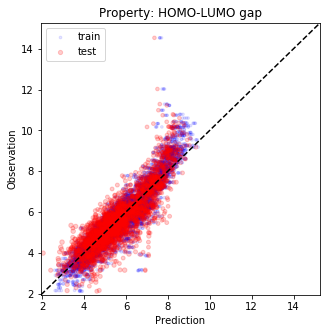

CPU times: user 4min 30s, sys: 8.07 s, total: 4min 38s
Wall time: 2min 51s


In [33]:
%%time

# forward model library from scikit-learn
from sklearn.linear_model import BayesianRidge
# xenonpy library for data splitting (cross-validation)
from xenonpy.datatools import Splitter

# property name will be used as a reference for calling models
prop = ['E','HOMO-LUMO gap']

# prepare indices for cross-validation data sets
sp = Splitter(data_ss.shape[0], test_size=0, cv=5)

# initialize output variables
y_trues, y_preds = [[] for i in range(len(prop))], [[] for i in range(len(prop))]
y_trues_fit, y_preds_fit = [[] for i in range(len(prop))], [[] for i in range(len(prop))]
y_preds_std, y_preds_std_fit = [[] for i in range(len(prop))], [[] for i in range(len(prop))]

# cross-validation test
for iTr, iTe in sp.cv():
    x_train = data_ss['SMILES'].iloc[iTr]
    x_test = data_ss['SMILES'].iloc[iTe]
    
    ss = pd.Series(x_train, name='rdkit_fp')
    fps_train = RDKit_FPs.transform(ss)
    ss = pd.Series(x_test, name='rdkit_fp')
    fps_test = RDKit_FPs.transform(ss)
    
    y_train = data_ss[prop].iloc[iTr]
    y_test = data_ss[prop].iloc[iTe]
    for i in range(len(prop)):
        mdl = BayesianRidge(compute_score=True)
        mdl.fit(fps_train, y_train.iloc[:,i])
        prd_train, std_train = mdl.predict(fps_train, return_std=True)
        prd_test, std_test = mdl.predict(fps_test, return_std=True)

        y_trues[i].append(y_test.iloc[:,i].values)
        y_trues_fit[i].append(y_train.iloc[:,i].values)
        y_preds[i].append(prd_test)
        y_preds_fit[i].append(prd_train)
        y_preds_std[i].append(std_test)
        y_preds_std_fit[i].append(std_train)


You will see that the performance is not so bad, especially inside the target region that we are aiming at.

In [ ]:
# plot results
dot_scale = [0.5, 20]
for i, x in enumerate(prop):
    y_true = np.concatenate(y_trues[i])
    y_pred = np.concatenate(y_preds[i])
    y_true_fit = np.concatenate(y_trues_fit[i])
    y_pred_fit = np.concatenate(y_preds_fit[i])
    y_pred_std = np.concatenate(y_preds_std[i])
    y_pred_std_fit = np.concatenate(y_preds_std_fit[i])
    xy_min = min(np.concatenate([y_true,y_true_fit,y_pred,y_pred_fit]))*0.95
    xy_max = max(np.concatenate([y_true,y_true_fit,y_pred,y_pred_fit]))*1.05
    
    plt.figure(figsize=(5,5))
    plt.scatter(y_pred_fit, y_true_fit,s=y_pred_std_fit*dot_scale[i]/2, c='b', alpha=0.1, label='train')
    plt.scatter(y_pred, y_true,s=y_pred_std*dot_scale[i], c='r', alpha=0.2, label='test')
    plt.title('Property: ' + x)
    plt.xlim(xy_min,xy_max)
    plt.ylim(xy_min,xy_max)
    plt.legend(loc='upper left')
    plt.xlabel('Prediction')
    plt.ylabel('Observation')
    plt.plot([xy_min,xy_max],[xy_min,xy_max],ls="--",c='k')
    plt.show()


***Warning: this module will take 1-2min to complete!

Now, we will give a full demonstration of building your own models using all the data and putting them into iQSPR. Of course, you can directly pick one of the trained model above to use as well.

When preparing your own forward models, you have to make sure the function returns (mean, std dev) because we currently only support a Gaussian likelihood model. In the future, user can prepare their own likelihood function as well, as long as it returns a log_likelihood value. 

In [34]:
%%time

# write down list of property name(s) for forward models
prop = ['E','HOMO-LUMO gap'] # match with data table for convenience

# calculate descriptor values for all SMILES in the data subset
ss = pd.Series(data_ss['SMILES'], name='rdkit_fp')
fps_train = RDKit_FPs.transform(ss)

# initialize a dictionary for model storage
mdls = {}

# fill in and train the models
for x in prop:
    mdls[x] = BayesianRidge()
    mdls[x].fit(fps_train, data_ss[x])
    
# import descriptor calculator and forward model to iQSPR
prd_mdls = BayesianRidgeEstimator(descriptor=RDKit_FPs, **mdls)

CPU times: user 50.7 s, sys: 1.1 s, total: 51.8 s
Wall time: 29.8 s


### N-gram preparation

***Warning: this module may take 3-5min to complete!

For prior, which is simply a molecule generator, we currently provide a N-gram model based on the extended SMILES language developed by our previous iQSPR developers. 

Note that because the default sample_order in NGram is 10, setting train_order=5 (max order to be used in iQSPR) when fitting will cause a warning, and XenonPy will automatically set sample_order=5 (actual order to be used when running the iQSPR).

In [35]:
%%time

# N-gram library in XenonPy-iQSPR
from xenonpy.inverse.iqspr import NGram

# initialize a new n-gram
n_gram = NGram()

# train the n-gram with SMILES of available molecules
n_gram.fit(data_ss['SMILES'],train_order=5)


/Users/stephenwu/anaconda/envs/xepy36_rdkit_newPd/lib/python3.6/site-packages/xenonpy/inverse/iqspr/modifier.py:48: RuntimeWarning: <sample_order> is greater than <train_order>,<sample_order> will be reduced to <train_order>
  '<sample_order> will be reduced to <train_order>', RuntimeWarning)


CPU times: user 2min 43s, sys: 1.56 s, total: 2min 44s
Wall time: 2min 52s


Let us take a look at the molecules generated by our trained N-gram.

In [36]:
np.random.seed(201903) # fix the random seed

# perform pure iQSPR molecule generation starting with 5 initial molecules
n_loop = 5
tmp = data_ss['SMILES'][:5]
for i in range(n_loop):
    tmp = n_gram.proposal(tmp)
    print('Round %i' % i,tmp)

['CC(C)CN1CC(C1)C1=CC=CC=C1', 'C1=CC(=CN=C1)S', 'C1=CC(=CC=C1CC(C(=O)O)N)Cl', 'CCCCCC(=O)OCC1=CC=C(C=C1)O', 'C1=CC(=C(C=C1O)C(=O)O)[N+](=O)[O-]']
['CC(C)CN1CC(C1)C1=CC=CC=C1', 'C1=CC(=CN=C1)Cl', 'C1=CC(=CC=C1CCCC(=O)O)OC', 'CCCCCC(=O)OCC1=CC=C(C=C1)C(C)N(CCCCC)C=C(C(=C)O)C(=O)N(C)S(=O)(=O)O', 'C1=CC(=C(C=C1O)C(=O)O)CCO']
['CC(C)CN1CC(C1)C1=CC=CC=C1', 'C1=CC(=CN=C1)C1=CC(=CC(=C1)OC)O', 'C1=CC(=CC=C1CCCC(=O)O)C(=O)C', 'CCCCCC(=O)OCC1=CC=C(C=C1)C(C)N(CCCCC)C=C(C(=C)O)C(=O)N(C)S(=O)C1=CC(=CC=C1NC(=O)C(CCCC1C(C(C1)O)O)N=C(N)N)O', 'C1=CC(=C(C=C1O)C(=O)O)CCN']
['CC(C)CN1CC(C1)C1=CC=CC=C1', 'C1=CC(=CN=C1)C1=CC(=CC=C1)Cl', 'C1=CC(=CC=C1CCCC(=O)O)Cl', 'CCCCCC(=O)OCC1=CC=C(C=C1)C(C)N(CCCCC)C=C(C(=C)O)C(=O)N(C)S(=O)C1=CC(=CC=C1NC(=O)C(CCCC1C(C(C1)O)O)N)OCC(CO)N', 'C1=CC(=C(C=C1O)O)N']
['CC(C)CN1CC(C1)C1=CC=CC=C1', 'C1=CC(=CN=C1)C#N', 'C1=CC(=CC=C1CCCCCC(=O)C(C1=CC=CC2=CC=CC=C2CCC2=CC=C(C=C2)Cl)NC(=N1)NCCCOC)C', 'CCCCCC(=O)OCC1=CC=C(C=C1)C(C)N(CCCCC)C=C(C(=C)O)C(=O)N(C)S(=O)C1=CC(=CC=C1NC(=O)C(CCCC

Our N-gram-based molecular generator runs as follow: (1) given a tokenized SMILES in the extended SMILES format, randomly delete N tokens from the tail, (2) generate the next token using the N-gram table until we hit a termination token or a pre-set maximum length, (3) if generation ended without a termination token, a simple gramma check will be performed trying to fix any invalid parts, and the generated molecule will be abandoned if this step fails. Because we always start the modification from the tail and SMILES is not a 1-to-1 representation of a molecule, we recommend users to use the re-order function to randomly re-order the extended SMILES, so that you will not keep modifying the same part of the molecule. To do so, you can use the "set_params" function or do so when you initialize the N-gram using "NGram(...)". In fact, you can adjust other parameters in our N-gram model this way.

Note that we did not re-order the SMILES when training our N-gram model, it is highly possible that a re-ordered SMILES during the generation process will lead to substrings that cannot be found in the pre-trained N-gram table, causing a warning message and the molecule will be kept the same.

In [37]:
# change internal parameters of n_gram generator
n_gram.set_params(del_range=[1,10],max_len=500, reorder_prob=0.5)

np.random.seed(201903) # fix the random seed

# perform pure iQSPR molecule generation starting with 10 PG molecules
n_loop = 5
tmp = data_ss['SMILES'][:5]
for i in range(n_loop):
    tmp = n_gram.proposal(tmp)
    print('Round %i' % i,tmp)
    

IndexError: get_prob: ['O', '=C', '(', 'O', ')', 'c'] not found in n-gram, iB=0, iR=0

To avoid getting stuck at certain molecular structures due to the re-order issue, we recommend two solutions: 

(1) Standardize the SMILES to a single format and avoid re-ordering during generation process. To avoid not modifying certain part of the molecule, pick a larger maximum number for "del_range". This way, you will save time on training the N-gram model, but probably need more iteration steps during the actual iQSPR run for convergence to your target property region.

(2) Expand your training set of SMILES by added re-ordered SMILES of each originally available SMILES. Be careful of the bias to larger molecules due to more re-order patterns for longer SMILES. This way, you will need longer time to train the N-gram model, but probably converge faster in the actual iQSPR run.

***Warning: this module may take 3-5min to complete!
(You can skip this part and proceed forward)

In [ ]:
# Method 1: use canonical SMILES in RDKit with no reordering
cans = [Chem.MolToSmiles(Chem.MolFromSmiles(smi)) for smi in data_ss['SMILES']]
n_gram_cans = NGram(reorder_prob=0)
n_gram_cans.fit(cans)

# save results
with open('ngram_cans.obj', 'wb') as f:
    pk.dump(n_gram_cans, f)

***Warning: this module may take 2-3hr to complete!
(You can skip this part and proceed forward)

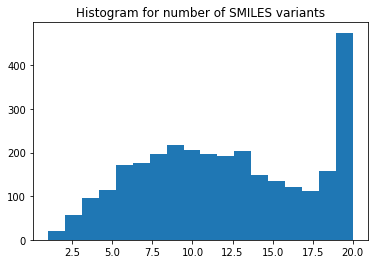

CPU times: user 1h 33min 34s, sys: 2min 13s, total: 1h 35min 48s
Wall time: 1h 36min 29s


In [39]:
%%time

np.random.seed(201903) # fix the random seed

# Method 2: expand n-gram training set with randomly reordered SMILES
# (we show one of the many possible ways of doing it)
n_reorder = 20 # pick a fixed number of re-ordering
mols = [Chem.MolFromSmiles(smi) for smi in cans]
smi_reorder = []
for mol in mols:
    idx = list(range(mol.GetNumAtoms()))
    np.random.shuffle(idx)
    tmp = [Chem.MolToSmiles(mol,rootedAtAtom=x) for x in range(min(len(idx),n_reorder))]
    smi_reorder.append(list(set(tmp)))

# plot the distribution of unique SMILES after re-ordering
n_uni = [len(x) for x in smi_reorder]
plt.hist(n_uni, bins='auto')  # arguments are passed to np.histogram
plt.title("Histogram for number of SMILES variants")
plt.show()

# flatten out the list and train the N-gram
flat_list = [item for sublist in smi_reorder for item in sublist]
n_gram_reorder = NGram(reorder_prob=0.5)
n_gram_reorder.fit(flat_list)

# save results
with open('ngram_reorder.obj', 'wb') as f:
    pk.dump(n_gram_reorder, f)

### iQSPR: sequential Monte Carlo

After the preparation of forward model (likelihood) and N-gram model (prior), we are now ready to perform the actual iteration of iQSPR to generate molecules in our target property region.

##### run iQSPR

We need to first set up some initial molecules as a starting point of our iQSPR iteration. Note that the number of molecules in this initial set governs the number of molecules generated in each iteration step. In practice, you may want at least 100 or even 1000 molecules per step depending your computing resources to avoid getting trapped in a local region when searching the whole molecular space defined by your N-gram model.

In [40]:
# set up initial molecules for iQSPR
np.random.seed(201903) # fix the random seed
cans = [Chem.MolToSmiles(Chem.MolFromSmiles(smi)) for i, smi in enumerate(data_ss['SMILES'])
       if (data_ss['HOMO-LUMO gap'].iloc[i] > 4)]
init_samples = np.random.choice(cans, 25)
print(init_samples)


['Oc1cc(Cl)ccc1Oc1ccc(Cl)cc1Cl' 'N#Cc1ccc(N)cc1'
 'O=C1CC2=C(CCN3CCc4cccc2c43)CO1' 'CN(C)C(=O)c1ccccc1'
 'O=C(O)c1cc([N+](=O)[O-])c(Cl)c([N+](=O)[O-])c1'
 'CCC1C(C)=NN=C(c2ccc(OC)c(OC)c2)c2cc(OC)c(OC)cc21'
 'FC(F)(F)C(F)(F)C(F)(F)C(F)(F)F' 'CCN(CC)CCN(c1ccccc1)C(C)C'
 'C=C1C(=O)OC2C1CCC(C)=CCCC1(C)OC21' 'NNC=O'
 'CCOC(OCC)C(C)Cc1ccc(C(C)C)cc1' 'N#CC(Br)c1ccccc1' 'CCOC(=O)c1ccc(O)cc1'
 'CCCCCCOC(=O)CCC' 'CCCCOCCCOC(=O)COc1cc(Cl)c(Cl)cc1Cl'
 'C=CCCCCCCCCC(=O)O' 'CC(C)C(C#N)(CCN1CCCCC1)c1ccccc1'
 'CC(C)C(NC(=O)C(CS)NC(=O)CCCC(N)C(=O)O)C(=O)O' 'CC(=O)Nc1ccccc1C(C)=O'
 'CCC(C(=O)OCCN1CCOC(c2ccccc2)C1C)c1ccccc1' 'C=C(Br)Br' 'CCc1cc(C)cc(C)c1'
 'Cc1cc(NC(=O)c2ccc(N)cc2)cc(C(=O)O)c1O' 'CCCCOC(=O)c1ccccc1C(=O)OCCCC'
 'Oc1ccc2c(c1)CCC2']


For any sequential Monte Carlo algorithm, annealing is usually recommended to avoid getting trapped in a local mode. In iQSPR, we use the beta vector to control our annealing schedule. We recommend starting with a small number close to 0 to minimize the influence from the likelihood at the beginning steps and using some kind of exponential-like schedule to increase the beta value to 1, which represents the state of the original likelihood. The length of the beta vector directly controls the number of iteration in iQSPR. We recommend adding more steps with beta=1 at the end to allow exploration of the posterior distribution (your target property region). In practice, iteration of the order of 100 or 1000 steps is recommended depending your computing resources.

In [41]:
# set up annealing schedule in iQSPR
beta = np.hstack([np.linspace(0.01,0.2,20),np.linspace(0.21,0.4,10),np.linspace(0.4,1,10),np.linspace(1,1,10)])
print('Number of steps: %i' % len(beta))
print(beta)


Number of steps: 50
[0.01       0.02       0.03       0.04       0.05       0.06
 0.07       0.08       0.09       0.1        0.11       0.12
 0.13       0.14       0.15       0.16       0.17       0.18
 0.19       0.2        0.21       0.23111111 0.25222222 0.27333333
 0.29444444 0.31555556 0.33666667 0.35777778 0.37888889 0.4
 0.4        0.46666667 0.53333333 0.6        0.66666667 0.73333333
 0.8        0.86666667 0.93333333 1.         1.         1.
 1.         1.         1.         1.         1.         1.
 1.         1.        ]


***Warning: this module may take 1-2min to complete!

Putting together the initial molecules, beta vector, forward model (likelihood), N-gram model (prior), you can now use a for-loop over the IQSPR class to get the generated molecules at each iteration step. More information can be extracted from the loop by setting "yield_lpf" to True (l: log-likelihood, p: probability of resampling, f: frequency of appearence). Note that the length of generated molecules in each step may not equal to the length of intial molecules because we only track the unique molecules and record their appearance frequency separately.

To save time, we have prepared a N-gram model trained with 5,000 molecules with 20 re-ordered copies. The file size might be a bit large to be loaded.

In [42]:
%%time

# library for running iQSPR in XenonPy-iQSPR
from xenonpy.inverse.iqspr import IQSPR

# load a pre-trained n-gram from the pickle file
with open('ngram_reorder_full.obj', 'rb') as f:
    n_gram_reorder = pk.load(f)
n_gram_reorder.set_params(del_range=[1,20],max_len=500, reorder_prob=0.5)

# set up likelihood and n-gram models in iQSPR
iqspr_reorder = IQSPR(estimator=prd_mdls, modifier=n_gram_reorder)
    
np.random.seed(201903) # fix the random seed
# main loop of iQSPR
iqspr_samples1, iqspr_loglike1, iqspr_prob1, iqspr_freq1 = [], [], [], []
for s, ll, p, freq in iqspr_reorder(init_samples, beta, yield_lpf=True, **{'E': (100, 200), 'HOMO-LUMO gap': (-np.inf,2)}):
    iqspr_samples1.append(s)
    iqspr_loglike1.append(ll)
    iqspr_prob1.append(p)
    iqspr_freq1.append(freq)
# record all outputs
iqspr_results_reorder = {
    "samples": iqspr_samples1,
    "loglike": iqspr_loglike1,
    "prob": iqspr_prob1,
    "freq": iqspr_freq1,
    "beta": np.hstack([0,beta]) # include the step of initial samples
}
# save results
with open('iQSPR_results_reorder.obj', 'wb') as f:
    pk.dump(iqspr_results_reorder, f)


CPU times: user 1min 16s, sys: 2.83 s, total: 1min 19s
Wall time: 1min 14s


##### plot results

Let us take a look at the results.

In [ ]:
with open('iQSPR_results_reorder.obj', 'rb') as f:
    iqspr_results_reorder = pk.load(f)

First, we look at how the likelihood values of the generated molecules converged to a distribution peaked around 1 (hitting the target property region). The gradient correlates well to the annealing schedule.

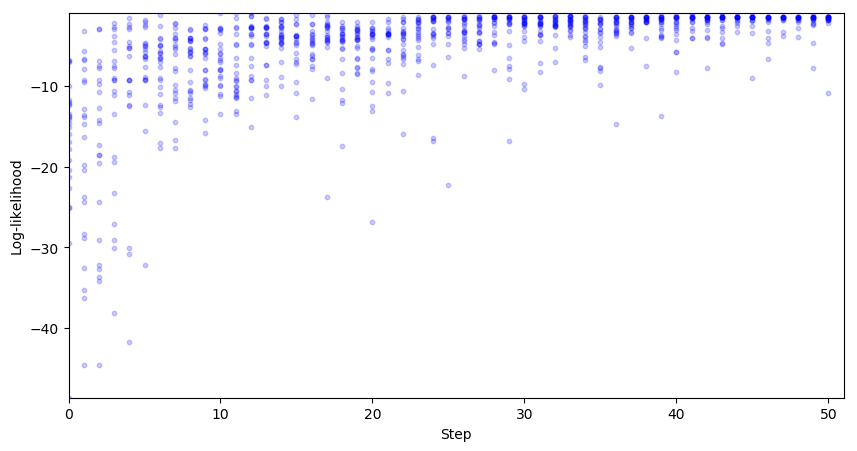

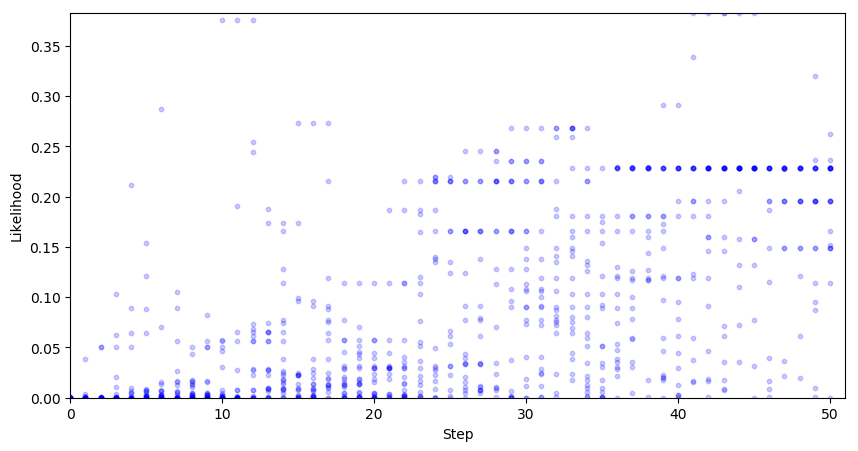

In [43]:
# plot the likelihood evolution

# set up the min and max boundary for the plots
flat_list = np.asarray([item for sublist in iqspr_results_reorder["loglike"] for item in sublist])
y_max, y_min = max(flat_list), min(flat_list)

plt.figure(figsize=(10,5))
plt.xlim(0,len(iqspr_results_reorder["loglike"]))
plt.ylim(y_min,y_max)
plt.xlabel('Step')
plt.ylabel('Log-likelihood')
for i, ll in enumerate(iqspr_results_reorder["loglike"]):
    plt.scatter([i]*len(ll), ll ,s=10, c='b', alpha=0.2)
plt.show()
#plt.savefig('iqspr_loglike_reorder.png',dpi = 500)
#plt.close()

y_max, y_min = np.exp(y_max), np.exp(y_min)
plt.figure(figsize=(10,5))
plt.xlim(0,len(iqspr_results_reorder["loglike"]))
plt.ylim(y_min,y_max)
plt.xlabel('Step')
plt.ylabel('Likelihood')
for i, ll in enumerate(iqspr_results_reorder["loglike"]):
    plt.scatter([i]*len(ll), np.exp(ll) ,s=10, c='b', alpha=0.2)
plt.show()
#plt.savefig('iqspr_like_reorder.png',dpi = 500)
#plt.close()


***Warning: this module may take 1-2min to complete!

Next, we plot the evolution of the generated molecules in the target property space.

In [51]:
%%time

# re-calculate the property values for the proposed molecules
x_mean, x_std, y_mean, y_std = [], [], [], []
r_std = []
FPs_samples = []
for i, smis in enumerate(iqspr_results_reorder["samples"]):
    ss = pd.Series(smis, name='rdkit_fp')
    tmp_fps = rdkit_fp.transform(ss)
    FPs_samples.append(tmp_fps)
    
    tmp1, tmp2 = mdls["E"].predict(tmp_fps, return_std=True)
    x_mean.append(tmp1)
    x_std.append(tmp2)
    
    tmp1, tmp2 = mdls["HOMO-LUMO gap"].predict(tmp_fps, return_std=True)
    y_mean.append(tmp1)
    y_std.append(tmp2)
    
    r_std.append([np.sqrt(x_std[-1][i]**2 + y_std[-1][i]**2) for i in range(len(x_std[-1]))])

# flatten the list for max/min calculation
flat_list = [item for sublist in r_std for item in sublist]
print('Range of std. dev.: (%.4f,%.4f)' % (min(flat_list),max(flat_list)))


Range of std. dev.: (32.2143,77.9013)
CPU times: user 46.7 s, sys: 3.39 s, total: 50.1 s
Wall time: 48.8 s


***Warning: this module may take 1-2min to complete!

In [ ]:
%%time

import os

# prepare a folder to save all the figures
ini_dir = './iQSPR_tutorial_prd/'
if not os.path.exists(ini_dir):
    os.makedirs(ini_dir)

flat_list = np.asarray([item for sublist in r_std for item in sublist])
s_max, s_min = max(flat_list), min(flat_list)
flat_list = np.concatenate((data_ss["E"],
    np.asarray([item for sublist in x_mean for item in sublist])))
x_max, x_min = max(flat_list), min(flat_list)
flat_list = np.concatenate((data_ss["HOMO-LUMO gap"],
    np.asarray([item for sublist in y_mean for item in sublist])))
y_max, y_min = max(flat_list), min(flat_list)
tmp_beta = np.hstack([0,beta])

for i in range(len(r_std)):
    dot_size = 45*((np.asarray(r_std[i])-s_min)/(s_max-s_min)) + 5
    
    plt.figure(figsize=(5,5))
    rectangle = plt.Rectangle((0,0),200,2,fc='y',alpha=0.1)
    plt.gca().add_patch(rectangle)
    plt.scatter(data_ss["E"], data_ss["HOMO-LUMO gap"],s=3, c='b', alpha=0.2)
    plt.scatter(x_mean[i], y_mean[i],s=dot_size, c='r', alpha=0.5)
    plt.title('Step: %i (beta = %.3f)' % (i,tmp_beta[i]))
    plt.xlim(x_min,x_max)
    plt.ylim(y_min,y_max)
    plt.xlabel('Internal energy')
    plt.ylabel('HOMO-LUMO gap')
    #plt.show()
    plt.savefig(ini_dir+'Step_%02i.png' % i,dpi = 500)
    plt.close()


***Warning: this module may take 10-15min to complete!

Finally, let us take a look at the generated molecular structures.

In [50]:
%%time

import os

# prepare a folder to save all the figures
ini_dir = './iQSPR_tutorial_smiles/'
if not os.path.exists(ini_dir):
    os.makedirs(ini_dir)

n_S = 25
for i, smis in enumerate(iqspr_results_reorder['samples']):
    tmp_smis = iqspr_results_reorder['samples'][i][
        np.argsort(iqspr_results_reorder['loglike'][i])[::-1]]
    fig, ax = plt.subplots(5, 5)
    fig.set_size_inches(20, 20)
    fig.set_tight_layout(True)
    for j in range(n_S):
        xaxis = j // 5
        yaxis = j % 5
        try:
            img = Draw.MolToImage(Chem.MolFromSmiles(tmp_smis[j]))
            ax[xaxis, yaxis].clear()
            ax[xaxis, yaxis].set_frame_on(False)
            ax[xaxis, yaxis].imshow(img)
        except:
            pass
        ax[xaxis, yaxis].set_axis_off()
    fig.savefig(ini_dir+'Step_%02i.png' % i,dpi = 500)
    plt.close()

Thank you for using XenonPy-iQSPR. We would appreciate any feedback and code contribution to this open-source project.